# Machine Learning Engineer Nanodegree
## Lin Muqing
## Capstone Model Iteration

In [1]:
import warnings
from imp import reload
warnings.filterwarnings('ignore')
import zillow_1 as z
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import os
if not os.path.exists('figs'):
    os.mkdir('figs')
import seaborn as sns
from IPython.display import display

%matplotlib inline
# util funcs

In [2]:
feature_info = pd.read_csv('data/feature_info.csv')
nmap_orig_to_new =  dict(zip(feature_info['orig_name'].values, feature_info['new_name'].values))
nmap_new_to_orig =  dict(zip(feature_info['new_name'].values, feature_info['orig_name'].values))

In [3]:
# load data
train_data, test_data = z.load_data_raw()

### naive_mean prediction

Log errors are already noise like, centered around zero (a little bit deviation from zero), heavy tailed. So firt try with a mean model.

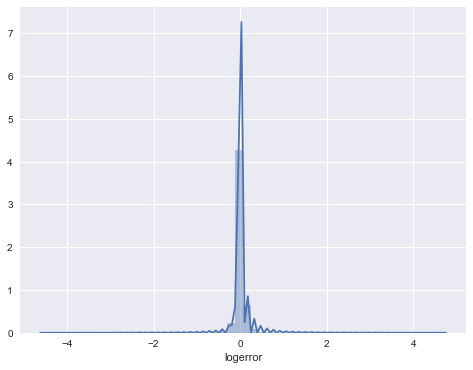

In [3]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
sns.distplot(train_data['logerror'], ax=ax)
fig.show()

In [4]:
# report train_data set mean, and cross validate mean model in train_data
print('mean logerror in train_data: %.6f' % np.mean(train_data['logerror']))
print('cv MAE in train_data: %.6f' % z.cv_mean_model(train_data['logerror']))

mean logerror in train_data: 0.011457
cv MAE in train_data: 0.068731


cv MAE in training data gives 0.068731, and on testing set, it is 0.0651282, This means training data has more extreme values than in testing data, yet, since these are actual transactions, we would not want to remove them for evaluation, and hopefully, we could some how gain prediction power on thoese extreme values.

Meanwhile, on testing set, predicting with mean is much better than predicting with 0 (0.0663010), meaning the positive bias in logerror is systemic.

### naive_lgb prediction.

Based on data exploration, I classified features into 4 categories, among them first class 1 and 2 are readily usable. So the benchmark model uses these features and tuned LightGBM, without

- outlier cleaning (neither x perspective or y perspective).
- feature engineering.
- handling seanality.
- handling outliers.

First take an overview of class1 and class2 features.

In [9]:
feature_info = pd.read_csv('data/feature_info.csv', index_col='new_name')
feature_info.drop('orig_name', axis=1, inplace=True)
keep_feature = feature_info.index[feature_info['class'].apply(lambda x: True if x in {1, 2} else False)].values
feature_select = feature_info.loc[keep_feature, :]
print(feature_select.shape)
display(feature_select.sort_values('class'))

(29, 4)


,type,class,prop_missing,train_missing
new_name,,,,
dollar_taxvalue_land,num,1,0.022689,0.000011
type_pool,cat,1,0.000000,0.000000
dollar_taxvalue_total,num,1,0.014254,0.000011
flag_tax_delinquency,cat,1,0.000000,0.000000
dollar_tax,num,1,0.010468,0.000067
dollar_taxvalue_structure,num,1,0.018418,0.004209
type_landuse,cat,1,0.003831,0.000000
area_lot,num,1,0.092489,0.112434
longitude,num,1,0.003831,0.000000


There are 29 of them in total, 8 of them are categorical.

Tuning LightGBM with CV, four parameters concentrating on:
- min_data_in_leaf.
- learning_rate.
- num_leaf.
- lambda_12.

Random search is used, result is evalued by correlation between MAE and each parameter value. If abs_corr is high meaning finer searching on one side in the range is meaningful, oherwise, we are indifferent in selecting a value in the range. Final used model is
- num_leaves = 40.
- learning_rate = 0.01.
- lambda_l2 = 0.02.
- min_data_in_leaf = 300.

Then number of boosting round is chosen by early_stopping_round together with validation. At last, final model for testing is trained on full data. All the following LightGBM tuning will be following this procedure.

In [16]:
reload(z)
test_x, train_x, train_y = z.load_data_naive_lgb(train_data, test_data)
lgb_train = lgb.Dataset(train_x, train_y)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'num_leaves': 40,
    'min_data_in_leaf': 300,
    'learning_rate': 0.01,
    'lambda_l2': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbosity': 0
}
gbm = lgb.train(params, lgb_train, num_boost_round=1000)
eval_hist = lgb.cv(params, lgb_train, num_boost_round=1000)
print('cv MAE naive LightGBM: %.6f' % eval_hist['l1-mean'][-1])

cv MAE naive LightGBM: 0.067154


The cv MAE is smaller than 0.068731 of naive mean, and on testing set it is 0.0645428. Now we check the real feature importance determined by model. LightGBM provides two types of feature importance, one by number of splits for each feature, and one by total gain from using each feature in split.

In [17]:
reload(z)
df_split, df_gain = z.feature_importance(gbm)
df_display = pd.concat([df_split, df_gain], axis=1, join='outer')
display(df_display)

,class,feature,split,class,feature,gain
0,1,year_built,3996,1,year_built,1764.673888
1,1,latitude,3866,1,dollar_tax,1680.953865
2,1,area_lot,3668,1,area_living_type_12,1667.419066
3,1,longitude,3471,1,latitude,1619.861319
4,1,dollar_tax,3452,1,area_living_finished_calc,1539.949818
5,1,dollar_taxvalue_structure,3340,1,area_lot,1461.527406
6,1,area_living_type_12,3170,1,longitude,1358.485645
7,1,dollar_taxvalue_land,2960,1,dollar_taxvalue_structure,1317.876901
8,1,area_living_finished_calc,2507,1,dollar_taxvalue_land,1182.509141
9,1,dollar_taxvalue_total,2216,1,dollar_taxvalue_total,1166.348316


There is an obvious positive rank correlation between model feature importance and mannual marked feature quality. Surprisingly, code_fips got a very low usage.

### selected_feature prediction

Naive version uses all usable features, let's see if higher quality and smaller set of features can improve model performance, or LightGBM is smart enough to do feature selection internally and can make use of anything if existing.

Original plan is to use all class 1 features, but according to feature importance results, there some adjustments:
- remove following class 1 features, due to low rank:
    - code_fips.
    - num_fullbath.
    - flag_spa_zillow
    - flag_tax_delinquency
- keep following class 2 features:
    - area_garage, I put it as class 2 because of relatively high missing rate. If the pattern is so rich, not only I would want to use it now, but I will try to have a good missing imputation for it.
    - rank_building_quality, it was put as class 2 becuase no obvious pattern at high density area. From results, it seems that low density group (6, 8) shaded the scale.
    - area_pool, it was also dropped due to weak pattern. Now it tells that the pattern is not drastic but good enough.
    - num_bathroom_assessor, could also be miss-classified by scale shading.
    - num_unit, it is not very strong, but we kept type_pool and type_heating_system.

In [5]:
reload(z)
test_x, train_x, train_y = z.load_data_naive_lgb_feature_down(train_data, test_data)

In [6]:
reload(z)
lgb_train = lgb.Dataset(train_x, train_y)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'num_leaves': 40,
    'min_data_in_leaf': 300,
    'learning_rate': 0.01,
    'lambda_l2': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbosity': 0
}
eval_hist = lgb.cv(params, lgb_train, num_boost_round=1000)
print('cv MAE naive LightGBM: %.6f' % eval_hist['l1-mean'][-1])

cv MAE naive LightGBM: 0.067191


Compared to naive version without feature downsize, the performance gets downgraded, meaning low quality features does not confuse LightGBM. 

### expanded_feature prediction

Now it worth looking if including class 4 features would improve the results.

In [7]:
reload(z)
test_x, train_x, train_y = z.load_data_naive_lgb_feature_up(train_data, test_data)
lgb_train = lgb.Dataset(train_x, train_y)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'num_leaves': 40,
    'min_data_in_leaf': 300,
    'learning_rate': 0.01,
    'lambda_l2': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbosity': 0
}
eval_hist = lgb.cv(params, lgb_train, num_boost_round=1500)
print('cv MAE naive LightGBM: %.6f' % eval_hist['l1-mean'][-1])

cv MAE naive LightGBM: 0.067143


lgb params are not further tuned, but num_boost_round is increased due to more noise. cv MAE gets decreased a little bit. So get curious in what it might do to testing data. Testing MAE gets improved from 0.0645428 to 0.0644639. 

In [10]:
gbm = z.train_lgb(train_x, train_y, 1500)
df_split, df_gain = z.feature_importance(gbm)
df_display = pd.concat([df_split, df_gain], axis=1, join='outer')
display(df_display)

,class,feature,split,class,feature,gain
0,1,year_built,5694,1,year_built,2108.283189
1,1,latitude,5539,1,latitude,2049.224820
2,1,area_lot,5539,1,area_lot,1926.511265
3,1,dollar_taxvalue_structure,5195,1,dollar_tax,1914.989072
4,1,longitude,5080,1,area_living_type_12,1909.168882
5,1,dollar_tax,4699,1,area_living_finished_calc,1846.284699
6,1,area_living_type_12,4462,1,longitude,1768.611371
7,1,dollar_taxvalue_land,4439,1,dollar_taxvalue_structure,1737.730846
8,1,area_living_finished_calc,3645,1,dollar_taxvalue_land,1545.368544
9,1,dollar_taxvalue_total,3435,1,dollar_taxvalue_total,1437.979522


Take a further look at feature importance, indeed most type 4 features are useless. Yet, the 5 that ranks high:
- area_living_type_15
- area_firstfloor_zillow
- area_firstfloor_assessor
- area_yard_patio
- year_tax_due

They are all put into class-4 due to high missing rate (+95%), thus patterns are not viewed at all. Further more, as put in data_explore section type_pool should have already included flag_pool and type_pool_2 information. Let's finalize our naive_lgb version with class12 plus these 5 features. 

### naive_lgb_final model

In [11]:
reload(z)
test_x, train_x, train_y = z.load_data_naive_lgb_final(train_data, test_data)
lgb_train = lgb.Dataset(train_x, train_y)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'num_leaves': 40,
    'min_data_in_leaf': 300,
    'learning_rate': 0.01,
    'lambda_l2': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbosity': 0
}
eval_hist = lgb.cv(params, lgb_train, num_boost_round=1500)
print('cv MAE naive LightGBM: %.6f' % eval_hist['l1-mean'][-1])

cv MAE naive LightGBM: 0.067142


Good to see cv MAE is not much compromised. Let's keep this as final naive_lgb model. On testing data, result is a bit worse off. from 0.0644639 to 0.0644925. It should be fine. And with less number of used features, model training and predicting process will be more efficient. 

### Feature Engineering

In this section, I will test adding or replacing one feature at a time. Engineered feature is expected to be strong, so:
- if it is a completely new feature, I will take a look at its average importance rank in both split and gain. A usable new feature should not be of last, say 10%. 
- if it is a feature to replace an existing feature. I will include both features in the model, and see if the new one performs better than the old one.